In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
set1 = pd.read_csv("./set1.csv")
set2 = pd.read_csv("./set2.csv")
set3 = pd.read_csv("./set3.csv")
set4 = pd.read_excel("./set4.xlsx", sheet_name=None)
set5 = pd.read_excel("./set5.xlsx", sheet_name="E31-17")
set6 = pd.read_csv("./set6.csv")

In [26]:
sets = [set1, set2, set3, set5, set6]
sets.extend([set4[i] for i in set4])
df = pd.concat(sets)

In [27]:
df.dropna(axis="index", how="all", inplace=True)

In [28]:
df.Date = pd.to_datetime(df.Date)

In [29]:
# Drop `barcode` because it was never used
# Drop `week` because it can be infered from the date
# Drop `timestamp` because it is Google sheets specific
# Drop `Status` because by now all transactions are posted
# Drop `Paid amount` because it can be infered from the amount and the shared value
df.drop(columns=["Barcode", "Week", "Timestamp", "Status", "Paid amount"], inplace=True)

In [30]:
def combine_verif(df, first, other):
    """
    Verfy there are no instances where the two 
    columns have a non null value simultaneously
    """
    return len(df[df[first].notnull() & df[other].notnull()]) == 0

In [31]:
# Combine Account and Payment method
#df.Account = df.Account.combine_first(df["Payment method"])
#df.Account.replace("Savings account", "Bank account", inplace=True)
#df.Account.fillna("Cash", inplace=True)
# Drop because no longer needed
df.drop(columns=["Payment method", "Account"], inplace=True) # Dropped because all values were cash after moving forward with cleaning

In [32]:
# Combine Item and Expense
df.Item = df.Item.combine_first(df.Expense)
# Drop because no longer needed
df.drop(columns=["Expense"], inplace=True)

In [33]:
# Cannot use obeservations without items
df.drop(df[df.Item.isnull()].index, inplace=True)
# Cannot use obeservations without dates
df.drop(df[df.Date.isnull()].index, inplace=True)

In [34]:
# Consider only expenses
df.drop(labels=df[df.Category == "Income"].index, inplace=True)
df.drop(labels=df[df.Category == "Transfer"].index, inplace=True)
df.drop(labels=df[df.Item == "Income"].index, inplace=True)
df.drop(labels=df[(df.Item == "Adjustement") | (df.Category == "Adjustment")].index, inplace=True)
df.drop(labels=df[df.Category == "Cash"].index, inplace=True)
df.drop(labels=df[df.Item == "Settle up loan"].index, inplace=True)
df.drop(labels=df[df.Item == "Given to dad"].index, inplace=True)
df.drop(labels=df[df.Item == "Loan"].index, inplace=True)

In [35]:
# Combine Amount and Monetary value
df.Amount = df.Amount.combine_first(df["Monetary value"])
# Cleanup currency symbol as it is all in one currency
df.Amount = df.Amount.transform(lambda x: float(str(x).replace("TND", "").replace("din", "")))
# Since all values are expenses, all of them can be positive keeping the fact they are expenses in mind
df.Amount = df.Amount.transform(abs)
# Multiply by 1000 to avoid floating points, using Millimes instead of Dinars
df.Amount = df.Amount.transform(lambda x: int(x * 1000))
# Drop because no longer needed
df.drop(columns=["Monetary value"], inplace=True)

In [36]:
# Combine Location and Payee
df.Payee = df.Payee.combine_first(df.Location)
# Drop because no longer needed
df.drop(columns="Location", inplace=True)

In [37]:
df.set_index("Date").head()

,Amount,Brand,Category,Item,Payee,Quantity,Share,Unit
Date,,,,,,,,
2017-06-08,1850,NaN,Transportation,Taxi,NaN,NaN,NaN,NaN
2017-06-08,280,NaN,Food,Tomatoes,NaN,NaN,NaN,NaN
2017-06-08,300,NaN,Food,Green pepper,NaN,NaN,NaN,NaN
2017-06-08,670,NaN,Food,Black pepper,NaN,NaN,NaN,NaN
2017-06-08,730,NaN,Food,Lettuce Chico,NaN,NaN,NaN,NaN


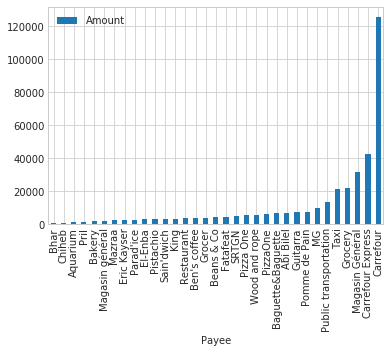

In [55]:
df[df.Payee.notnull()][["Payee", "Amount"]].groupby("Payee").aggregate(sum).sort_values(by="Amount").plot(kind="bar")